In [1]:
import sys

!{sys.executable} -m pip install sox
!{sys.executable} -m pip install torchaudio


In [2]:
import os
import json
import csv
import pandas as pd
import torchaudio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [3]:
def extract_metadata(json_file):
    """Extract metadata from the JSON file."""
    with open(json_file, 'r') as file:
        data = json.load(file)

    # Extracting relevant metadata
    metadata = {}
    for item in data['levels']:
        if item['name'] == 'utterance':
            for label in item['items'][0]['labels']:
                metadata[label['name']] = label['value']
    return metadata

def process_directory(directory, output_csv):
    """Process each 'sesxxx' directory and write metadata to a CSV file."""
    headers_set = False

    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile)

        file_patterns = ['_h_00_annot.json', '_h_01_annot.json', '_h_02_annot.json', '_h_03_annot.json', '_h_04_annot.json']
        for root, dirs, files in os.walk(directory):
            for file in files:
                if any(file.endswith(pattern) for pattern in file_patterns):
                    json_file = os.path.join(root, file)
                    metadata = extract_metadata(json_file)

                    utterance = metadata.get('utterance', 'unknown')
                    file_path = os.path.join(root, utterance + '.wav')
                    metadata['file_path'] = file_path

                    # Writing headers to CSV file
                    if not headers_set:
                        headers = metadata.keys()
                        csvwriter.writerow(headers)
                        headers_set = True

                    # Writing data to CSV file
                    csvwriter.writerow(metadata.values())

# # Replace 'your_directory_path' with the path to the ALC dataset directory
# directory_path = 'ALC/'
# output_csv_file = 'output.csv'

# process_directory(directory_path, output_csv_file)


In [4]:
df = pd.read_csv('../output.csv')

df.head()


,utterance,utt,spn,o_utt,item,o_item,alc,sex,age,acc,...,ges,ces,wea,irreg,anncom,specom,type,content,file_path,duration
0,0471048008_h_00,471048008,47,472044008.0,8,8.0,a,M,28,BY,...,f5,r1,SUN,3|2|2|1|0|1|1|0|1,NaN,NaN,R,A,ALC/ses1048/0471048008_h_00.wav,9.25
1,0471048011_h_00,471048011,47,472044031.0,11,31.0,a,M,28,BY,...,f5,r1,SUN,9999|0|0|0|0|0|0|0|0,NaN,NaN,L,N,ALC/ses1048/0471048011_h_00.wav,4.50
2,0471048023_h_00,471048023,47,472044059.0,23,59.0,a,M,28,BY,...,f5,r1,SUN,0|0|0|0|0|0|0|0|0,NaN,NaN,R,R,ALC/ses1048/0471048023_h_00.wav,2.24
3,0471048007_h_00,471048007,47,472044023.0,7,23.0,a,M,28,BY,...,f5,r1,SUN,1|0|2|0|0|1|0|0|0,NaN,NaN,R,T,ALC/ses1048/0471048007_h_00.wav,11.00
4,0471048024_h_00,471048024,47,472044051.0,24,51.0,a,M,28,BY,...,f5,r1,SUN,0|0|0|0|0|0|0|0|0,NaN,NaN,R,R,ALC/ses1048/0471048024_h_00.wav,3.50


In [11]:
def get_wav_duration(file_path):
    waveform, sample_rate = torchaudio.backend.sox_io_backend.load(f"../{file_path}")
    return waveform.shape[1] / sample_rate

def add_duration_column(csv_file, output_csv_file):
    """Add a 'duration' column to the CSV file."""
    df = pd.read_csv(csv_file)

    # List to store durations
    durations = []

    # Iterating over the DataFrame to compute durations
    for index, row in df.iterrows():
        wav_file = row['file_path']
        if os.path.exists(f"../{wav_file}"):
            duration = get_wav_duration(wav_file)
            durations.append(duration)
        else:
            print(f"File not found: {wav_file}. Setting duration as NaN.")
            durations.append(float('nan'))

    # Adding the duration column to the DataFrame
    df['duration'] = durations

    # Saving the updated DataFrame to a new CSV file
    df.to_csv(output_csv_file, index=False)

    return df

# Replace with your actual CSV file names
input_csv_file = '../output.csv'
output_csv_file = '../output.csv'
df_with_durations = add_duration_column(input_csv_file, output_csv_file)


/var/folders/63/gs9jxkdx5yx3qrqxb436c3240000gn/T/ipykernel_83394/131690967.py:2: UserWarning: Torchaudio's I/O functions now support par-call bakcend dispatch. Importing backend implementation directly is no longer guaranteed to work. Please use `backend` keyword with load/save/info function, instead of calling the udnerlying implementation directly.
  waveform, sample_rate = torchaudio.backend.sox_io_backend.load(f"../{file_path}")


In [13]:
df = pd.read_csv('../output.csv')

df["alc"]


0        a
1        a
2        a
3        a
4        a
        ..
15175    a
15176    a
15177    a
15178    a
15179    a
Name: alc, Length: 15180, dtype: object

In [14]:
print(len(df[df["alc"] == "na"]))
print(len(df[df["alc"] == "a"]))
print(len(df[df["alc"] == "cna"]))


9720
4860
600


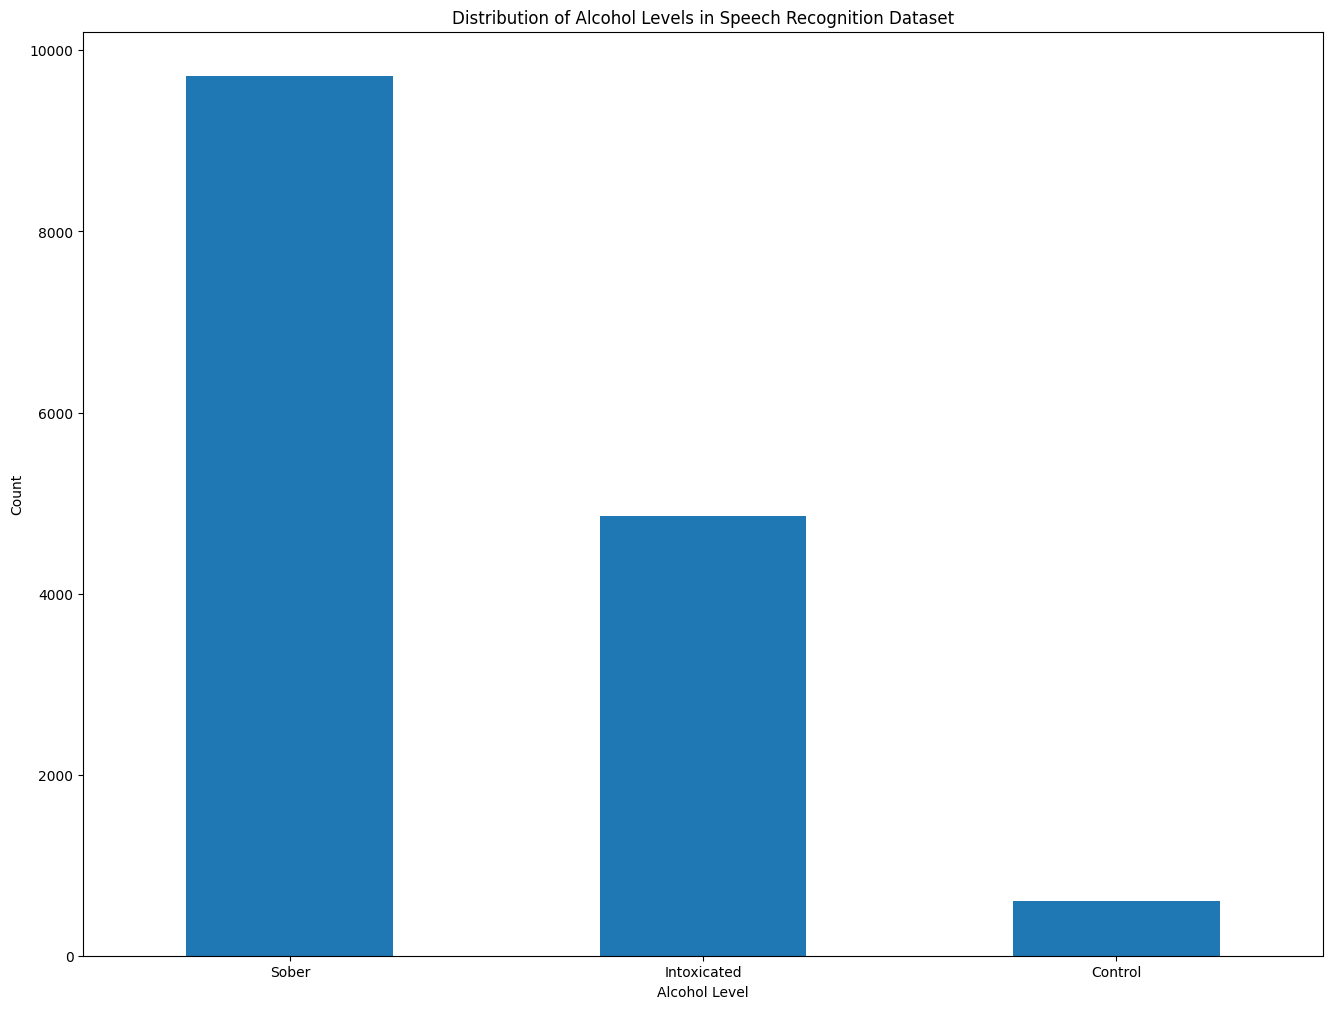

In [15]:
alc_mapping = {'a': 'Intoxicated', 'na': 'Sober', 'cna': 'Control'}
df['alc_mapped'] = df['alc'].map(alc_mapping)

# Plotting the distribution of the mapped 'alc' values
plt.figure(figsize=(16, 12))
df['alc_mapped'].value_counts().plot(kind='bar')
plt.xlabel('Alcohol Level')
plt.ylabel('Count')
plt.title('Distribution of Alcohol Levels in Speech Recognition Dataset')
plt.xticks(rotation=0)
plt.show()


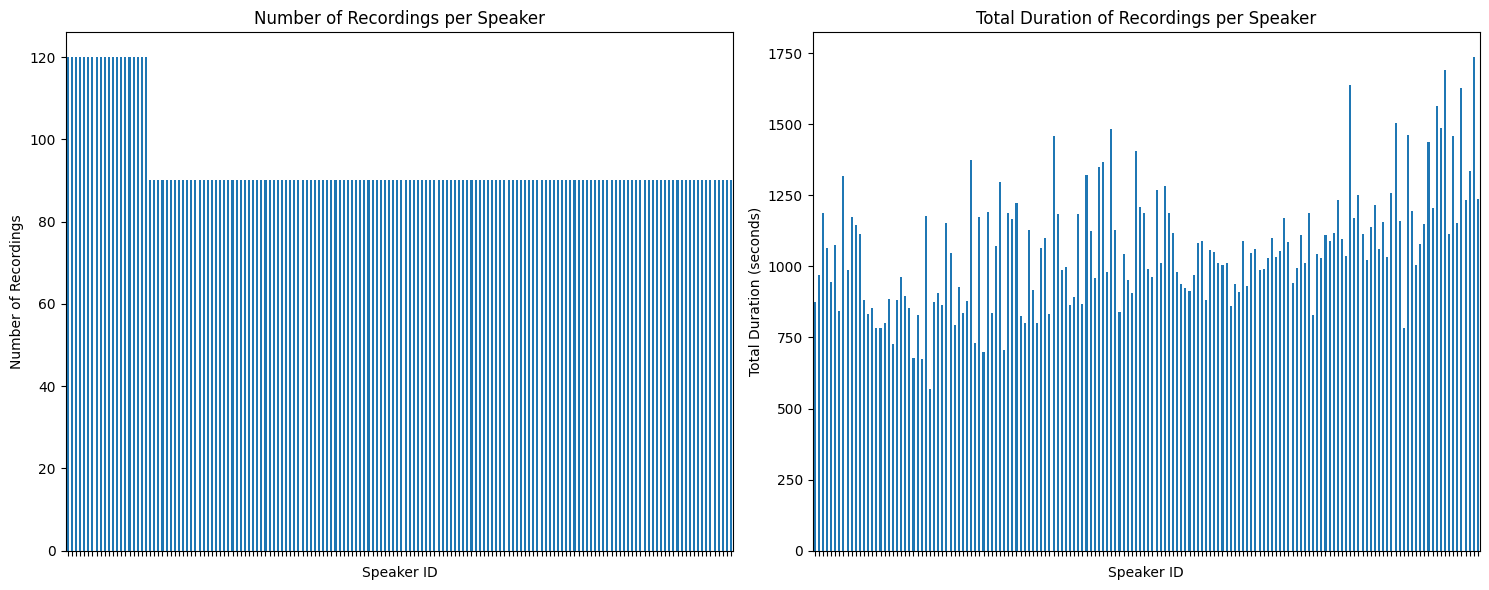

In [16]:
# 1) Histogram showing the relationship between speaker ID and the number of recordings
speaker_counts = df['spn'].value_counts()
total_duration_per_speaker = df.groupby('spn')['duration'].sum()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

speaker_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Number of Recordings per Speaker')
axes[0].set_xlabel('Speaker ID')
axes[0].set_ylabel('Number of Recordings')
axes[0].set_xticklabels([])

# Plot for Total Duration of Recordings per Speaker
total_duration_per_speaker.plot(kind='bar', ax=axes[1])
axes[1].set_title('Total Duration of Recordings per Speaker')
axes[1].set_xlabel('Speaker ID')
axes[1].set_ylabel('Total Duration (seconds)')
axes[1].set_xticklabels([])

# Adjusting layout
plt.tight_layout()
plt.show()


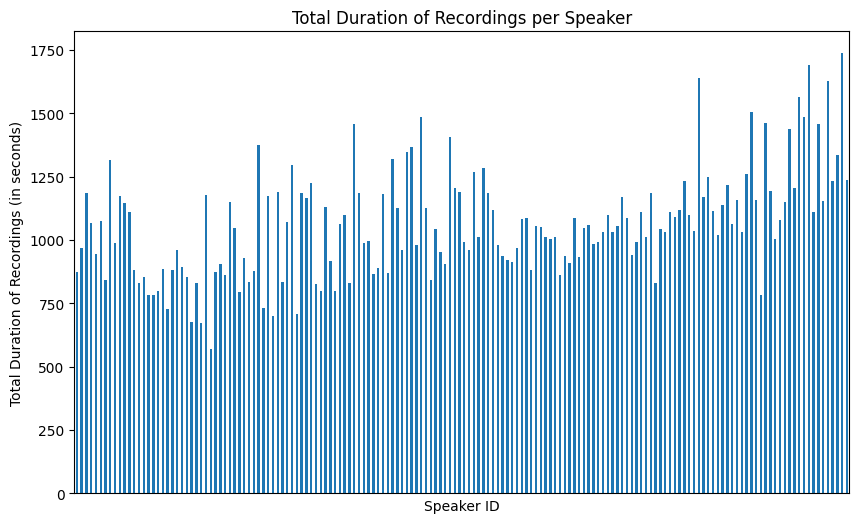

In [17]:
total_duration_per_speaker = df.groupby('spn')['duration'].sum()

plt.figure(figsize=(10, 6))
total_duration_per_speaker.plot(kind='bar')
plt.xlabel('Speaker ID')
plt.ylabel('Total Duration of Recordings (in seconds)')
plt.title('Total Duration of Recordings per Speaker')
plt.xticks([])
plt.show()


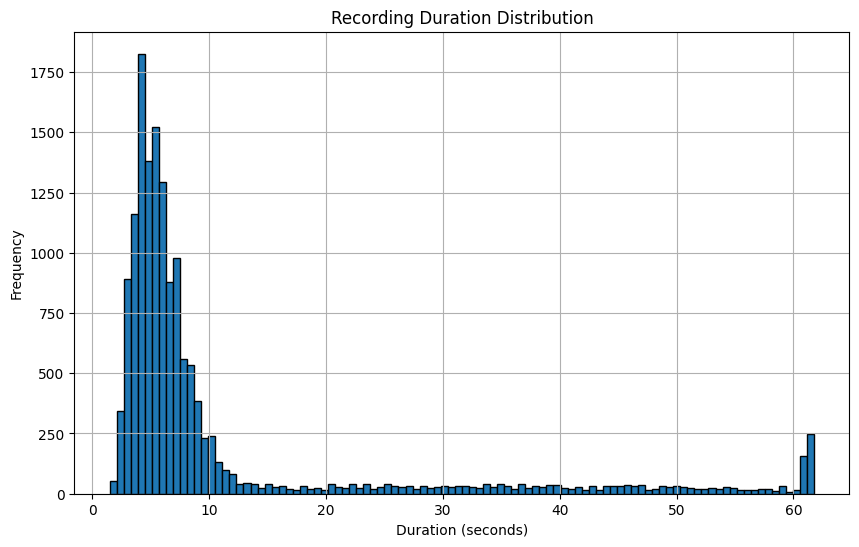

In [18]:
def plot_duration_histogram(df, column='duration', bins=100):
    """
    Plot a histogram for the specified column in the DataFrame.

    :param df: pandas DataFrame containing the data.
    :param column: The name of the column to plot, default is 'duration'.
    :param bins: Number of bins for the histogram, default is 50.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(df[column].dropna(), bins=bins, edgecolor='black')
    plt.title('Recording Duration Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Assuming df_with_durations is your DataFrame with the duration column
plot_duration_histogram(df)


In [12]:
df2 = df[df['duration'] >= 10]

df2.nunique()


utterance     3093
utt           3093
spn            162
o_utt         2022
item            43
o_item          36
alc              3
sex              2
age             30
acc             14
drh              3
aak             93
bak             88
ges              9
ces              3
wea              2
irreg         2283
anncom           0
specom           4
type             5
content          8
file_path     3093
duration      1193
alc_mapped       3
dtype: int64

In [19]:
unique_speakers = df['spn'].unique()

train_speakers, test_speakers = train_test_split(unique_speakers, test_size=0.2, random_state=42)

print(len(train_speakers))
print(len(test_speakers))

train_df = df[df['spn'].isin(train_speakers)]
test_df = df[df['spn'].isin(test_speakers)]

print(f"Number of training samples: {len(train_df)}")
print(f"Number of testing samples: {len(test_df)}")

total_duration_train = train_df['duration'].sum()
total_duration_test = test_df['duration'].sum()

print(f"Total duration of training data: {total_duration_train} seconds")
print(f"Total duration of testing data: {total_duration_test} seconds")


129
33
Number of training samples: 12030
Number of testing samples: 3150
Total duration of training data: 137057.07868480726 seconds
Total duration of testing data: 35307.90242630385 seconds


In [20]:
# save the dataframes to csv files
train_df.to_csv('../train2.csv', index=False)
test_df.to_csv('../test2.csv', index=False)


In [21]:
# get the difference between train.csv and train2.csv
df1 = pd.read_csv('../train.csv')
df2 = pd.read_csv('../train.csv')


0.0